#### 5 year Forecasting With Online Sales


In [8]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [9]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [10]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [11]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [12]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [13]:
online_channel= df.loc[df['Region'] == 'United Kingdom',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
11,2011-06-02,Online,699.0982,United Kingdom
17,2011-06-04,Online,3578.2700,United Kingdom
24,2011-06-05,Online,3578.2700,United Kingdom
25,2011-06-06,Online,3578.2700,United Kingdom
32,2011-06-08,Online,3399.9900,United Kingdom
...,...,...,...,...
60371,2014-06-30,Online,34.9900,United Kingdom
60372,2014-06-30,Online,49.9900,United Kingdom
60377,2014-06-30,Online,4.9900,United Kingdom
60378,2014-06-30,Online,4.9900,United Kingdom


### Data Preprocessing

In [14]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [15]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-06-02,699.0982
1,2011-06-04,3578.2700
2,2011-06-05,3578.2700
3,2011-06-06,3578.2700
4,2011-06-08,3399.9900
...,...,...
776,2014-06-26,46.4700
777,2014-06-27,179.5100
778,2014-06-28,148.9800
779,2014-06-29,53.9800


### Indexing with Time Series Data

In [16]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-06-02', '2011-06-04', '2011-06-05', '2011-06-06',
               '2011-06-08', '2011-06-10', '2011-06-11', '2011-06-14',
               '2011-06-21', '2011-06-23',
               ...
               '2014-06-20', '2014-06-21', '2014-06-22', '2014-06-23',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='OrderDate', length=781, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [17]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [18]:
y['2014':]

OrderDate
2014-01-01    6781.100968
2014-02-01    6278.014286
2014-03-01    6065.280645
2014-04-01    6881.717000
2014-05-01    8465.397419
2014-06-01     143.791379
Freq: MS, Name: Total_Sales, dtype: float64

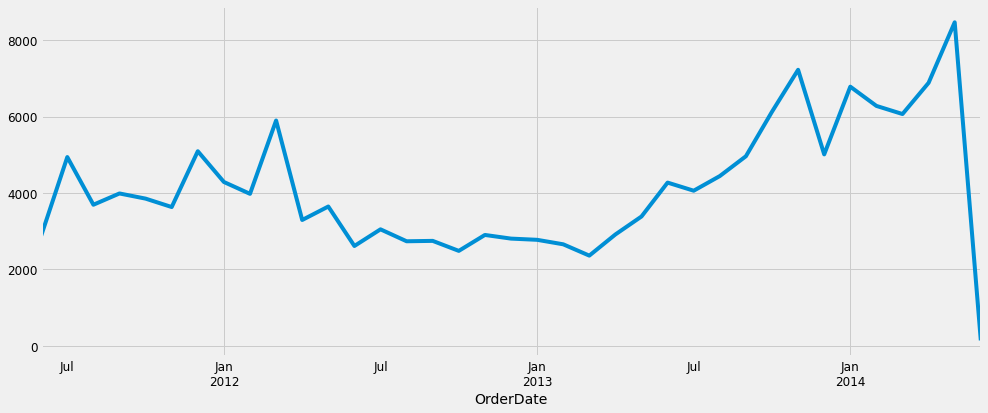

In [19]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

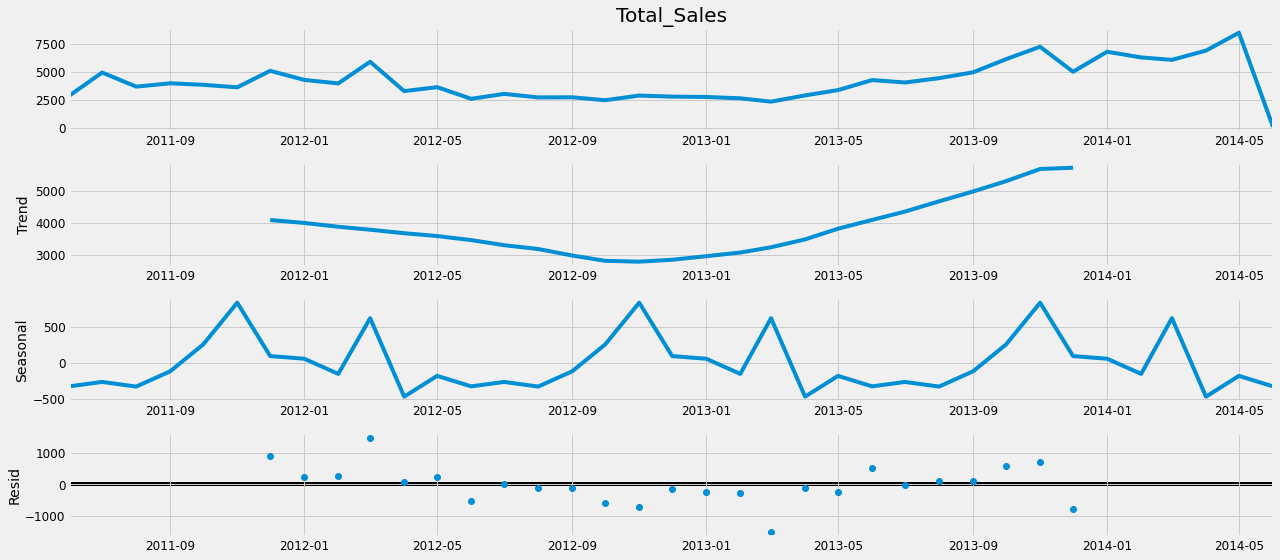

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [22]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:709.871916618908
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1006.1373994399337
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:450.0651875855996
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:233.01437491332675
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:469.64354079868014
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:439.9909735526652
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:241.1355971637326
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:220.1030463169366
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:660.8900132199724
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1982.848894584249
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:426.2491199313712
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:213.27263705877448
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:463.3467010531639
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:423.8662430608505
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:242.54669611115665
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:202.69670293634874
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:622.2949188883161
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:416.4573437342311
ARIMA

 ### Fitting an ARIMA Time Series Model

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3189      0.998     -0.320      0.749      -2.274       1.636
ma.L1         -0.9945      4.275     -0.233      0.816      -9.373       7.384
ar.S.L12      -1.4285      0.660     -2.164      0.030      -2.722      -0.135
ma.S.L12       1.6796      3.835      0.438      0.661      -5.837       9.196
sigma2      1.368e+06   4.18e-06   3.27e+11      0.000    1.37e+06    1.37e+06


### Validating forecasts

In [24]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


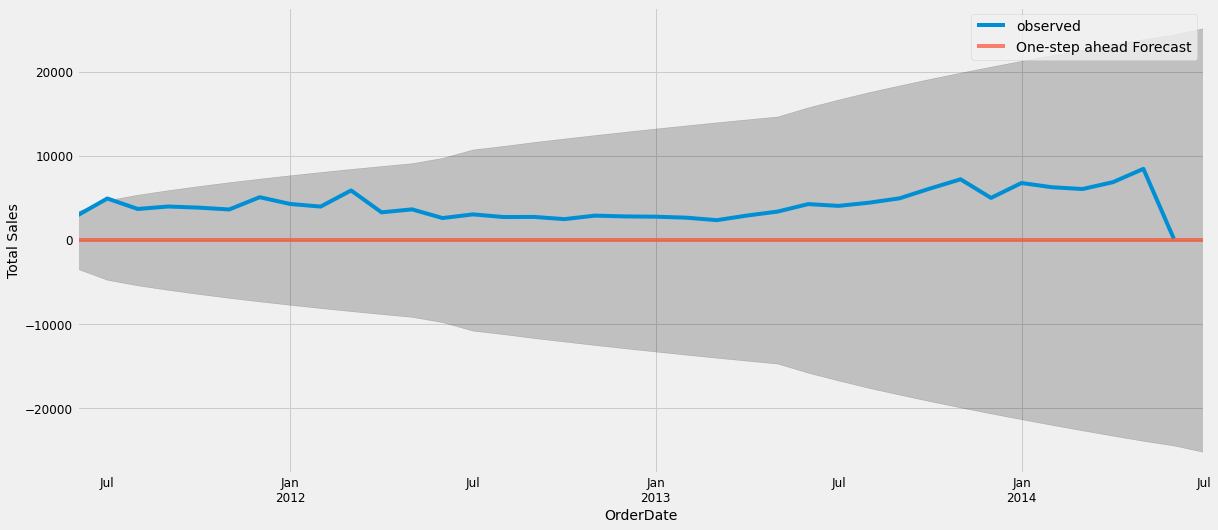

In [26]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

In [27]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 40204346.88


In [28]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6340.69


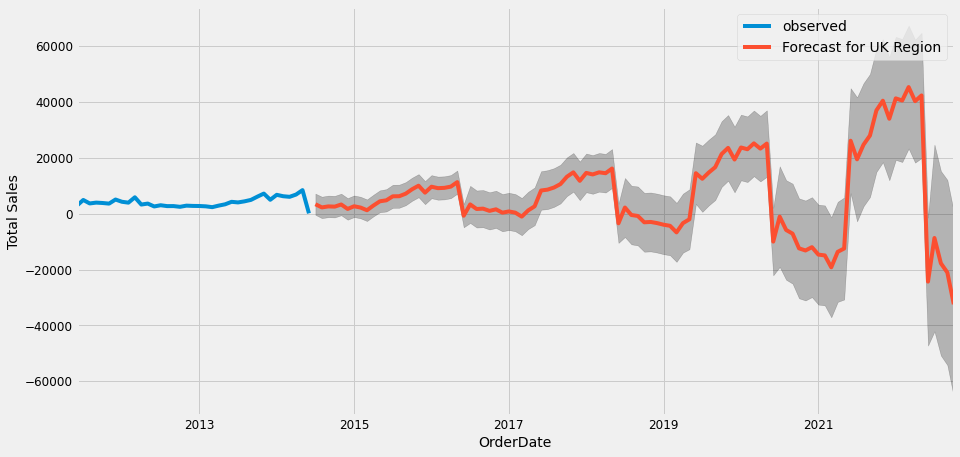

In [29]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for UK Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()